# Computational Phenotyping

In this notebook, we will apply some unsupervised and supervised learning techniques in order to analyze phenotypic data.

## Data import

First, we load the training data, as saved by [CellCognition](https://www.cellcognition-project.org). CellCognition saves the training set data as an `arff` file. In this file, we have all features for the annotated training samples and the class of each sample, saved in the last column.

In [478]:
from scipy.io import arff
import pandas as pd
import numpy as np

data = arff.loadarff('./data/classifier/Classifier_2016_09_27/data/features.arff')
df = pd.DataFrame(data[0])

df.head()

,ch_acd,ch_area_ratio,ch_cc,ch_max_val_0,ch_max_val_1,ch_max_val_2,ch_mean_area,ch_rugosity,ch_thresh_cc,ch_variance_area,...,n_wdist,n_wiavg,perimeter,princ_gyration_ratio,princ_gyration_x,princ_gyration_y,roisize,skewness_x,skewness_y,class
0,0.185820,0.979365,3.0,0.011345,0.003241,0.003241,3.666667,1.000000,0.0,5.555556,...,101.418152,4.223985,109.0,0.805489,0.314666,0.253460,617.0,0.040712,0.034170,"b""'Interphase'"""
1,0.130861,0.979466,1.0,0.008386,0.002096,0.002096,4.000000,1.000000,0.0,0.000000,...,88.884696,5.293019,98.0,0.578352,0.371080,0.214615,477.0,0.012314,0.021238,"b""'Interphase'"""
2,0.112675,0.965847,5.0,0.008487,0.008487,0.007072,4.400000,1.000000,0.0,2.640000,...,118.427157,4.756058,122.0,0.756439,0.325152,0.245957,707.0,0.013256,0.065063,"b""'Interphase'"""
3,0.119475,0.960784,2.0,0.024943,0.004535,0.002268,6.500000,0.989691,0.0,20.250000,...,76.238095,6.136124,97.0,0.700851,0.339339,0.237826,441.0,0.105154,0.059443,"b""'Interphase'"""
4,0.088142,0.952769,7.0,0.011966,0.006838,0.006838,3.571429,0.990991,0.0,2.530612,...,96.374359,4.041816,111.0,0.790491,0.318146,0.251491,585.0,0.000860,0.059826,"b""'Interphase'"""


We next would like to load the class definitions. They are saved as a tab-delimited text file, containing:
- the label of the class
- the string representation of the class
- the color that has been chosen during annotation

We will therefore import these definitions by reading the csv-file.

In [479]:
import csv

In [480]:
fp = open('./data/classifier/Classifier_2016_09_27/class_definition.txt', 'r')
reader = csv.reader(fp, delimiter='\t')
name_to_label = {}
label_to_name = {}
lut = {}
for label, class_name, class_color in reader:
    name_to_label[class_name] = int(label)
    label_to_name[int(label)] = class_name
    lut[int(label)] = class_color

In [481]:
label_to_name

{1: 'Interphase',
 2: 'MAP',
 3: 'Prometaphase',
 4: 'Metaphase',
 5: 'Anaphase',
 8: 'Apoptosis',
 9: 'Polylobed',
 11: 'Elongated'}

The `arff`-file we have imported contains both the class labels and the features. Obviously, we need to separate in order to train classifiers, etc. We will therefore create a design matrix $X$ containing all columns of the data frame and an $y$ vector containing the class labels (where we take the labels from class_definition, rather than the string representation).

In [482]:
y = np.array([name_to_label[x.decode("utf-8").strip('\'')] for x in df['class']])

In [483]:
X = df.drop('class', axis=1)

In [484]:
X.shape

(875, 235)

We have now built our training set. We have 875 samples (annotated nuclei) and 235 features for each.

## Data Cleaning and Preprocessing

The next step is to check whether there are `Nan`'s in the data. `Nan` means "not a number"; this typically happens if a feature value was not defined for some reason (e.g. division by zero). 

In [485]:
nb_nans = np.isnan(X).sum().sum()

In [486]:
print ('Number of Nan in the data: %i' % nb_nans)

Number of Nan in the data: 0


We see that there are no `Nan`s, so we can proceed. It must be noted that some learning algorithms can deal with `Nan`s, but often it is worth thinking about how to avoid them altogether, if possible. This is of course only possible if the data scientist can control the entire workflow.

The next thing to check is whether there are features with zero-variance. They certainly contain absolutely no information (they are constant over all classes), and nothing can be learned from them. 

In [487]:
X.columns[np.where(np.std(X)==0)]

Index(['dyn_distance_radius_3'], dtype='object')

Apparently, there is one feature that does not vary for the entire data set, we can therefore safely remove it. Again, for many Machine Learning algorithm, it does not hurt to keep the feature, but for some it can be detrimental. We therefore prefer to remove the corresponding column.

In [488]:
X = df.drop(['dyn_distance_radius_3', 'class'], axis=1)
print(X.shape)

(875, 234)


We next normalize the data. We clearly saw that the different features we are using ave very different ranges (some are between 0 and 1, others can reach very high values). Again, data normalization is not necessary for all machine learning algorithms. For some however, it is absolutely essential to apply data normalization before. Imagine for instance that you just calculate the Euclidean distance between data points $\|x_i - x_j\|_2$ (for instance for the purpose of clustering or visualization). In this case a feature with absolute values would completely dominate this metric. Here we use a standard normalization (zero mean and unity variance). If $x_j$ is one feature (column of $X$), we define $x^{norm}_j$ as:

\begin{equation}
x^{norm}_j = \frac{x_j - \mu(x_j)}{\sigma_{x_j}}  
\end{equation}

In [489]:
Xnorm=(X-X.mean())/X.std()

In [490]:
np.mean(Xnorm).head()

ch_acd           2.112342e-15
ch_area_ratio   -3.993631e-15
ch_cc            1.147019e-16
ch_max_val_0     5.790923e-16
ch_max_val_1     4.040577e-16
dtype: float64

In [491]:
np.std(Xnorm).head()

ch_acd           0.999428
ch_area_ratio    0.999428
ch_cc            0.999428
ch_max_val_0     0.999428
ch_max_val_1     0.999428
dtype: float64

From now on, we work only on normalized features (i.e. we omit $norm$ in the formulas and set `X` to `Xnorm`.

In [492]:
X = Xnorm

## Visualization of the data and unsupervised analyses

We next turn to look at the data and show several ways of visually analyzing the data set. While this is often neglected in theoretical talks, looking at the data is usually an important part of a data scientist's work. It must be noted that in many real-world applications, in particular in biology, the definition of classes is not necessarily obvious and can undergo some modification during a project's lifetime. It is therefore important to get an idea about the trends in your data.

One way of looking at the data is to visualize joint distributions of features via scatterplots of feature pairs.

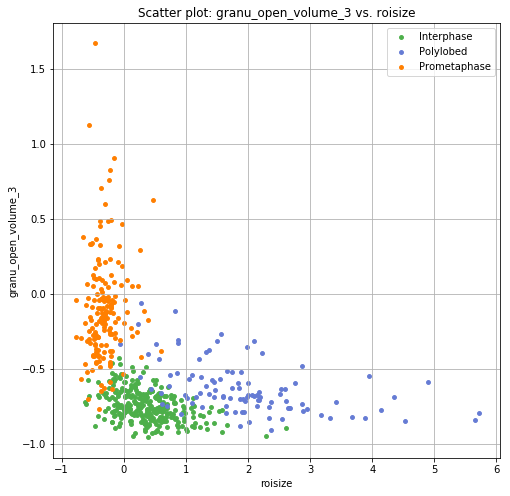

In [493]:
def make_scatterplot(X, y, feature1, feature2, class_names):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title('Scatter plot: %s vs. %s' % (feature2, feature1))

    for class_name in class_names:
        class_label = name_to_label[class_name]
        class_color = lut[class_label]
        ax.scatter(X[feature1][y==class_label],
                   X[feature2][y==class_label],
                   c=class_color, 
                   s=15)
    ax.legend(class_names)
    ax.grid()

make_scatterplot(X, y, 'roisize', 'granu_open_volume_3', 
                 ['Interphase', 'Polylobed', 'Prometaphase'])

Here, we plot a texture feature (morphological granulometries of size 3) and the number of pixels, i.e. one shape and one texture descriptor. We see that these features are quite discriminative between these classes. Not surprisingly, the pixelsize is capable of distinguishing between polylobed and interphase / prometaphase and the texture feature is capable of distinguishing prometaphase from interphase / polylobed. So we see that there is signal, but we also notice that the classes are far from being separable (by taking just these two features).

Sometimes, you might be tempted to reduce the number of features by removing features with little or no discriminative power and features that are strongly correlated to other features, as they -  so the idea - convey similar information. Let us take for instance 2 features describing second order statistics (`h1_2VAR` and `h4_1VAR`) and calculate the overall correlation.

In [494]:
np.corrcoef(X['h1_2VAR'], X['h4_2VAR'])

array([[1.        , 0.92006312],
       [0.92006312, 1.        ]])

We thus see that we get a strong correlation of these two features (0.92) suggesting that we could safely remove one of them without loosing much information.

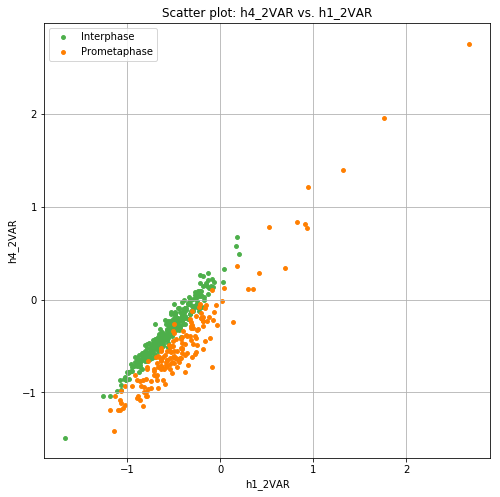

In [495]:
make_scatterplot(X, y, 'h1_2VAR', 'h4_2VAR', ['Interphase', 'Prometaphase'])

<font color=blue *Question: How do you interpret this graph? What can be said about the importance of the two features?*>

<font color=red> *How do you interpret this plot? Are these features useful?*</font>

The next way of visualizing the data is to find a low dimensional reprentation. There are many methods in order to achieve this goal. The two most popular methods are Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE). In the following, we will apply these methods on our training data.  

PCA projects the feature data onto a space where all components are orthogonal to each other and have maximal variance.

In [496]:
from sklearn.decomposition import PCA

In [497]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

In [498]:
import matplotlib.pyplot as plt

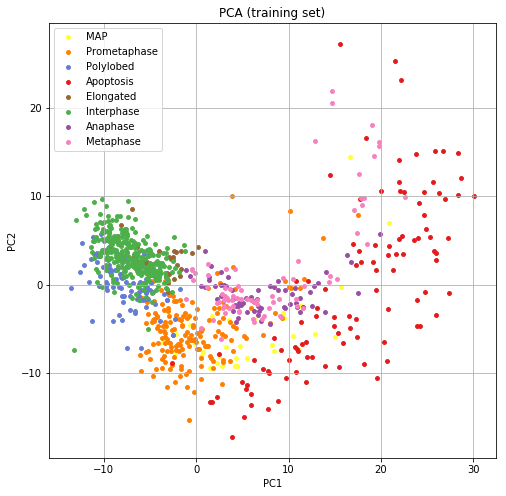

In [499]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA (training set)')

class_names = class_definition.keys()
for class_name in class_names:
    class_label = name_to_label[class_name]
    class_color = lut[class_label]
    ax.scatter(principalComponents[y==class_label][:,0],
               principalComponents[y==class_label][:,1],
               c=class_color, 
               s=15)
ax.legend(class_names)
ax.grid()

<font color=red> *Observations? Which classes would you expect to be difficult to classify correctly? How do you interpret the different region sizes occupied by different classes?*</font>

Next, we turn to a newer projection technique which is widely used in Machine Learning, but also in Computational Biology (in particular for sequencing data): t-SNE. In this method, one considers the probabilities $p_{ij}$ of two points $x_i$ and $x_j$ to be considered as neighbors. t-SNE aims at finding a low-dimensional feature space, where the distribution of the corresponding $q_{ij}$ are as close as possible to $p_{ij}$ in the sense of KL-divergence:
\begin{equation}
KL(P\|Q) = \sum_{i\not= j}p_{ij}\log\frac{p_{ij}}{q_{ij}}
\end{equation}

In [500]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)

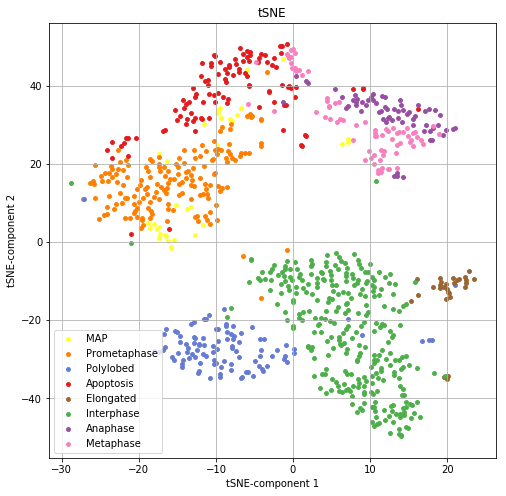

In [501]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tSNE-component 1')
ax.set_ylabel('tSNE-component 2')
ax.set_title('tSNE')

class_names = class_definition.keys()
for class_name in class_names:
    class_label = name_to_label[class_name]
    class_color = lut[class_label]
    ax.scatter(X_embedded[y==class_label][:,0],
               X_embedded[y==class_label][:,1],
               c=class_color, 
               s=15)
ax.legend(class_names)
ax.grid()

<font color=red> *How does this compare to the results obtained by PCA?*</font>

<font color=red> *Test different values of perplexity.*</font>

In [502]:
import seaborn as sns

In [503]:
colorvec = [lut[label] for label in y]
cmap = sns.diverging_palette(10, 220, sep=80, n=30)

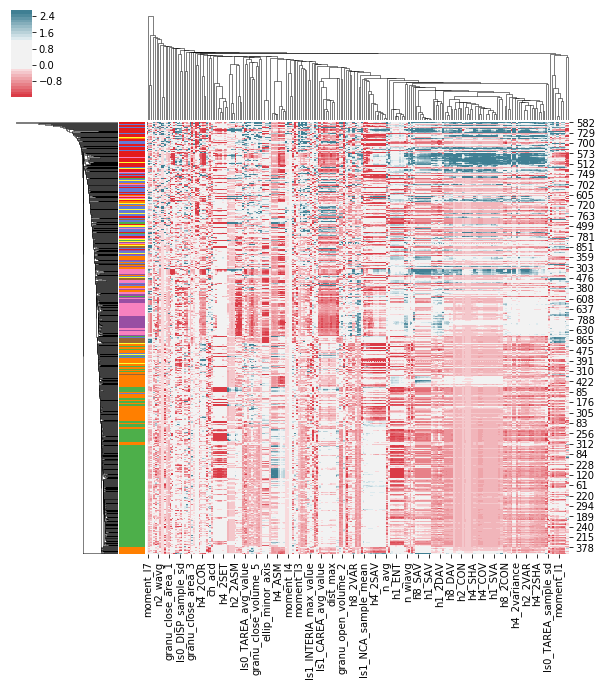

In [532]:
g = sns.clustermap(X, method='single', metric='euclidean', 
                   row_colors=colorvec, robust=True, cmap=cmap)

<font color=red> *Try different agglomeration functions: single, complete, average, centroid, Ward (check in the sklearn documentation, what they mean and conclude, which one you would like to use).* </font>

Again, we observe that some classes can be well distinguished, others are clustered together. When interpreting such a plot, it is essential to also look at the dendrogram. Actually, the true clustering information is represented by the dendrogram and not by the order of the rows. Indeed, I could flip the cluster order at any merging point of the dendrogram without changing the clustering result provided by the hierarchical clustering. In the above example with `method="ward"` and `metric="euclidean"`, this concerns for instance the distinction between the lower part of the anaphase/metaphase block and the apoptosis block next to it: in reality, these cells are (wrongly) clustered together.

## Supervised Learning

We will now train classifiers on our training set. Here, we train Random Forest Classifiers (RF) and Support Vector Machines (SVM) in order to recognize nuclear morphologies.

#### Random Forests

Random Forests are ensemble methods, where decision trees are trained on random subsets of the training data, where each split is performed on one feature. This feature is chosen from a random subset of the features in order to optimize the purity of the resulting sets.

In [505]:
from sklearn.ensemble import RandomForestClassifier

Now, we need to define the hyperparameters. In practice, on our kind of data, the most important parameter to be set is the number of trees in the forest. In general, the higher this number the better it is, but the resulting classifier will be slower also. Importantly, this parameter does not only affect training time, but also prediction time. For us however, this is not critical, and we set this parameter to 200. The second parameter is the `oob_score` which indicates whether to calculate the out-of-bag error. This is an error wich is only calculated on those samples that were left out for training the tree. Using the out-of-bag error allows us to avoid time-consuming cross-validation.

In [506]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True)

Now, we can train our classifier. 

In [507]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [508]:
print('overall accuracy: %.2f' % rf.oob_score_)

overall accuracy: 0.96


We will now calculate the confusion matrix. 

In [509]:
prediction_result = rf.oob_decision_function_

In [510]:
classification_result = np.argmax(prediction_result, axis=1)

In [518]:
from sklearn.metrics import confusion_matrix

class_labels = np.array(sorted(label_to_name.keys()))
cm_rf = confusion_matrix(y, class_labels[classification_result])

print(', '.join([label_to_name[l] for l in class_labels]))
print(cm_rf)

Interphase, MAP, Prometaphase, Metaphase, Anaphase, Apoptosis, Polylobed, Elongated
[[294   0   0   0   0   0   1   1]
 [  0  21   9   3   0   2   0   0]
 [  1   2 166   0   0   0   0   0]
 [  0   1   0  71   2   1   0   0]
 [  0   0   0   1  61   2   0   0]
 [  0   2   2   0   1 101   1   0]
 [  2   0   1   0   0   0  97   1]
 [  1   0   0   1   0   0   0  26]]


#### Support Vector Machines (SVM)

Here, training is formulated as a convex optimization problem under constraints:

\begin{eqnarray*}
\min_{w,\xi} & & \|w\|^2 + C \sum_{i=1}^{N}\xi_i\\
\mbox{subject to} & & y_i(w^Tx_i + b) \geq 1 - \xi_i \quad i = 1, \ldots, N \\
& & \xi_i \geq 0 \quad i = 1, \ldots, N
\end{eqnarray*}

The only parameter to be fixed is $C$, which controls the compromise between classifcation errors and regularization (the higher $C$ is chosen, the more weight is given to correct classification of training samples). There is no way of guessing $C$ and so we need to test different values of $C$ and choose the value that leads to the best performance. 

In [410]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [519]:
clf = svm.SVC(C=0.01, kernel='linear')

It is very important to evaluate the performance of the classifier by cross-validation: the training error is not equal to the test error. We are going to show this. First, we calculate the training error.

In [520]:
clf.fit(X,y)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [521]:
print('accuracy measured on the training set: %.2f' % np.mean(clf.score(X,y)))

accuracy measured on the training set: 0.98


In [522]:
score = cross_val_score(clf, X, y, cv=10)

In [523]:
print('accuracy measured by 10-fold cross validation: %.2f' % np.mean(score))

accuracy measured by 10-fold cross validation: 0.95


As expected, we see that the performance on the training set is better than on the test set. Indeed, evaluating the performance on the training set is a typical mistake in machine learning, as this always gives overoptimistic results. While in this case, this was easy to avoid, it is sometimes more challenging to know whether our performance evaluation is correct in that it does not intermingle training and test set.

Here, we obtain a very similar result to what we obtained from the RF classifier, even though we use a linear kernel and did not yet optimize the parameter $C$.

In [524]:
from sklearn.model_selection import GridSearchCV

In [525]:
parameters = {'C':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 500]}

In [526]:
gs = GridSearchCV(clf, parameters, cv=10)

In [527]:
gs.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [528]:
gs.best_score_

0.9577142857142857

In [529]:
gs.cv_results_['mean_test_score']

array([0.95428571, 0.95771429, 0.95314286, 0.94971429, 0.94971429,
       0.94971429, 0.94971429, 0.94971429, 0.94971429])

From here, we see that for this case, optimization of the parameter $C$ only marginally changes the accuracy. This is unusual, but it can happen.